In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
regret_rsv_dict_list = []
regret_worst_dict_list = []
regret_central_dict_list = []
regret_cstat_dict_list = []
coll_rsv_dict_list = []
coll_worst_dict_list = []

# System Parameters
T = 20000
num_users = 9
num_svrs = 9
num_locs = 9
# mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big
svr_offset_uniform = 2
max_dists = [3,5,10,15,20]

num_explore = 1
trials = 5

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)

In [4]:
for zt in range(len(max_dists)):
    # Recording Mechanism
    regret_centralized_dict = {}

    regret_worst_dict = {}
    collisions_worst_dict = {}

    regret_rsv_dict = {}
    collisions_rsv_dict = {}

    regret_cent_stat = {}
    mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])


    for tri in range(trials):



#         svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs)
        # Create Users
        Users_w = []
        for i in range(num_users):
            P_temp = P_collection
            Users_w += [User(usr_locs,svr_locs,mu[i],i,
                          max_dist = max_dists[zt], threshold_dist = 6, self_weight = 1 - 0.85, P = P_temp, ceiling = 1,
                          sticky_mode = True, kick_mode=True)]

        # Create Servers
        Servers = []
        for i in range(num_svrs):
            Servers += [Server(svr_locs[i],mu,i)]

        # Recorded Values - reservation
        regret_g = np.zeros(T) # Got
        collision_count_g = np.zeros(T)
        optimal_reward_g = np.zeros(T)

        regret_w = np.zeros(T) # Worst
        collision_count_w = np.zeros(T)
        optimal_reward = np.zeros(T)

        # Explore rounds are common/shared across all users
        explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                       usr_move_flag = True, rounds=num_explore)

        round_start = ((num_svrs)*num_explore)+1


        # Other reward recodings
        Users_rsv = copy.deepcopy(Users_w)
        regret_rsv = copy.deepcopy(regret_w)
        collision_count_rsv = copy.deepcopy(collision_count_w)
        for u in Users_rsv:
            u.sticky_mode = True
            u.kick_mode = True #false
            u.ceiling = ceiling
            u.expected_time_true = u.get_expected_time()

        # Centralized - true w learning
        rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_ct = copy.deepcopy(regret_w)

        # Centralized - stationary w learning
        rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_cs = copy.deepcopy(regret_w)

        # Centralized - stationary w, known mu
        w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
        optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
        regret_cst = copy.deepcopy(regret_w)

        for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
            w = obtain_w(Users_w, len(Users_w), len(Servers))
            optimal = offline_optimal_action(w, mu)
            optimal_reward[t] = optimal[1]

            # Distributed solution 
            play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                       usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
            play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                       usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t)
            copy_usr_loc(Users_w, Users_rsv)

            # Centralized Solution -  true w learning
            ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
            arms = offline_optimal_action(w, ucb_ct)[0]
            rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
            regret_ct[t] = optimal[1] - expected_reward(arms, mu, w)

            # Centralized Solution -  stationary w learning
            ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
            arms = offline_optimal_action(w_stat, ucb_cs)[0]
            rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
            regret_cs[t] = optimal[1] - expected_reward(arms, mu, w)


        regret_centralized_dict[tri] = copy.deepcopy(regret_ct)

        regret_worst_dict[tri] = copy.deepcopy(regret_w)
        collisions_worst_dict[tri] = copy.deepcopy(collision_count_w)

        regret_rsv_dict[tri] = copy.deepcopy(regret_rsv)
        collisions_rsv_dict[tri] = copy.deepcopy(collision_count_rsv)

        regret_cent_stat[tri] = copy.deepcopy(regret_cs)
#         regret_opt_stat[tri] = copy.deepcopy(regret_cst)


        del Users_w, Users_rsv, Servers
    regret_rsv_dict_list += [regret_rsv_dict]
    regret_worst_dict_list += [regret_worst_dict]
    regret_central_dict_list += [regret_centralized_dict]
    regret_cstat_dict_list += [regret_cent_stat]
    coll_rsv_dict_list += [collisions_rsv_dict]
    coll_worst_dict_list += [collisions_worst_dict]

<ipython-input-4-4fac97bad34e>:72: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):


In [5]:
save_dict = {}
save_dict['regret_rsv_dict_list'] = regret_rsv_dict_list
save_dict['regret_worst_dict_list'] = regret_worst_dict_list
save_dict['regret_central_dict_list'] = regret_central_dict_list
save_dict['regret_cstat_dict_list'] = regret_cstat_dict_list
save_dict['coll_rsv_dict_list'] = coll_rsv_dict_list
save_dict['coll_worst_dict_list'] = coll_worst_dict_list

with open("experiments/save/exp4/220725_run3_t5.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

In [4]:
with open("experiments/save/exp4/220725_run3_t5.pkl", "rb") as handle:
    load_dict = pickle.load(handle)
    
regret_rsv_dict_list = load_dict['regret_rsv_dict_list']
regret_worst_dict_list = load_dict['regret_worst_dict_list']
regret_central_dict_list = load_dict['regret_central_dict_list']
regret_cstat_dict_list = load_dict['regret_cstat_dict_list']

coll_rsv_dict_list = load_dict['coll_rsv_dict_list']
coll_worst_dict_list = load_dict['coll_worst_dict_list']

In [5]:
regret_worst_dict_list[0][0]

array([2.70027228, 3.41321904, 2.84594329, ..., 2.07530718, 2.07530718,
       0.        ])

In [6]:
nt = len(list(regret_rsv_dict_list))
cc = len(max_dists)

# calculating error bars
regret_worst_sd = np.zeros([cc,nt])
regret_rsv_sd = np.zeros([cc, nt])
regret_cent_stat_sd = np.zeros([cc, nt])
regret_centralized_sd = np.zeros([cc, nt])

collisions_worst_sd = np.zeros([cc,nt])
collisions_rsv_sd = np.zeros([cc, nt])

for i in range(cc):
    for j in range(nt):
        regret_worst_sd[i,j] = np.cumsum(regret_worst_dict_list[i][j])[-1]
        regret_rsv_sd[i,j] = np.cumsum(regret_rsv_dict_list[i][j])[-1]
        regret_cent_stat_sd[i,j] = np.cumsum(regret_cstat_dict_list[i][j])[-1]
        regret_centralized_sd[i,j] = np.cumsum(regret_central_dict_list[i][j])[-1]
        
        collisions_worst_sd[i,j] = np.cumsum(coll_worst_dict_list[i][j])[-1]
        collisions_rsv_sd[i,j] = np.cumsum(coll_rsv_dict_list[i][j])[-1]

regret_worst_sd2 = np.sqrt(regret_worst_sd.var(1))
regret_rsv_sd2 = np.sqrt(regret_rsv_sd.var(1))
regret_cent_stat_sd2 = np.sqrt(regret_cent_stat_sd.var(1))
regret_centralized_sd2 = np.sqrt(regret_centralized_sd.var(1))
collisions_worst_sd2 = np.sqrt(collisions_worst_sd.var(1))
collisions_rsv_sd2 = np.sqrt(collisions_rsv_sd.var(1))
        
x = max_dists
regret_rsv_plot = []
regret_worst_plot = []
regret_central_plot = []
regret_cstat_plot = []

for zt in range(len(max_dists)):
    
    regret_rsv_avg = 1/trials * regret_rsv_dict_list[zt][0]
    regret_worst_avg= 1/trials * regret_worst_dict_list[zt][0]
    regret_centralized_avg = 1/trials * regret_central_dict_list[zt][0]
    regret_cent_stat_avg= 1/trials * regret_cstat_dict_list[zt][0]

    
    for i in range(1, trials):

        regret_rsv_avg += 1/trials * regret_rsv_dict_list[zt][i]
        regret_worst_avg += 1/trials * regret_worst_dict_list[zt][i]
        regret_centralized_avg += 1/trials * regret_central_dict_list[zt][i]
        regret_cent_stat_avg += 1/trials * regret_cstat_dict_list[zt][i]
    
    regret_rsv_plot += [copy.deepcopy(np.cumsum(regret_rsv_avg)[-1])]
    regret_worst_plot += [copy.deepcopy(np.cumsum(regret_worst_avg)[-1])]
    regret_central_plot += [copy.deepcopy(np.cumsum(regret_centralized_avg)[-1])]
    regret_cstat_plot += [copy.deepcopy(np.cumsum(regret_cent_stat_avg)[-1])]

In [7]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=-0.5, n=8)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


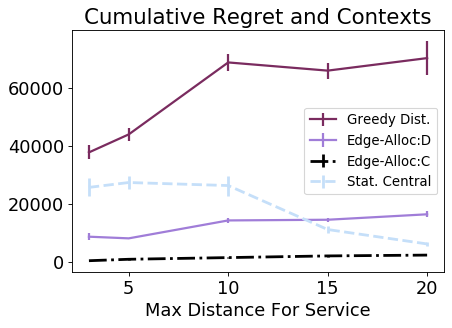

In [9]:
plt.figure(figsize=(6, 4), dpi=80)

# plt.errorbar(x, regret_worst_plot, regret_worst_sd2, label = 'Greedy Dist.', color = "tab:green", linewidth=2.0)
# plt.errorbar(x,regret_rsv_plot, regret_rsv_sd2, label = 'Edge-Alloc:D', color = "tab:red", linewidth=2.0)


# plt.errorbar(x,regret_central_plot, regret_centralized_sd2, label = 'Edge-Alloc:C', color = "tab:blue", linewidth=2.5,
#             linestyle='dashdot')
# plt.errorbar(x,regret_cstat_plot, regret_cent_stat_sd2, label = 'Stat. Central', color = "tab:orange", linewidth=2.5, 
#             linestyle='dashed')

plt.errorbar(x, regret_worst_plot, regret_worst_sd2, label = 'Greedy Dist.', color = np.divide(palette.colors[2],255), linewidth=2.0)
plt.errorbar(x,regret_rsv_plot, regret_rsv_sd2, label = 'Edge-Alloc:D', color = np.divide(palette.colors[4],255), linewidth=2.0)


plt.errorbar(x,regret_central_plot, regret_centralized_sd2, label = 'Edge-Alloc:C', color = np.divide(palette.colors[0],255), linewidth=2.5,
            linestyle='dashdot')
plt.errorbar(x,regret_cstat_plot, regret_cent_stat_sd2, label = 'Stat. Central', color = np.divide(palette.colors[6],255), linewidth=2.5, 
            linestyle='dashed')


#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)


plt.title('Cumulative Regret and Contexts')
plt.xlabel('Max Distance For Service')
plt.legend(prop={'size': 12})

In [41]:
regret_rsv_sd2

array([1241.50249485,  113.65619468,  746.7216483 ,  605.14170355,
       1060.84780878])

In [44]:
np.sqrt(regret_rsv_sd.var(1))

array([1241.50249485,  113.65619468,  746.7216483 ,  605.14170355,
       1060.84780878])

In [47]:
regret_centralized_sd2

array([ 29.63378938,  81.45758364,  91.12640478, 247.31337423,
        87.32355442])